# Imports

In [3]:
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import AdamW
import os
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from tabulate import tabulate
import matplotlib.pyplot as plt

torch.manual_seed(42)
np.random.seed(42)

In [4]:
BATCH_SIZE = 16
EPOCHS = 10

TEST_PATH = "testdata.csv"
TRAIN_PATH= "traindata.csv"
EVAL_PATH = "evaldata.csv"
SAVE_PATH= "models/Big5"

In [5]:
def import_data(path):
    dataset = pd.read_csv(path)
    return dataset
train_data = import_data(TRAIN_PATH)
test_data = import_data(TEST_PATH)
eval_data = import_data(EVAL_PATH)

In [6]:
class Big5Classifier:
    def __init__(self, model_name='distilbert-base-uncased', num_classes=2):
        # Initialize models here
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels = num_classes)

    def get_tokenizer_and_model(self):
        return self.model, self.tokenizer  

In [19]:
def get_dataset_split(data, big5category):
    #cateogry can be "OPN", "CON", "EXT", "AGR", "NEU"
    # Index 0 is taken for text_column due to the naming of the column in the dataset
    text_column = f"text{big5category[0]}"
    category_column = f"c{big5category}"

    # Check if the required columns exist
    if text_column in data.columns and category_column in data.columns:
        return data[[text_column, category_column]].rename(
            columns={text_column: "essay", category_column: "decision"}
        )    
    else:
        raise ValueError(f"Columns for category '{big5category}' are not present in the dataset.")
    

In [7]:
class DatasetLoader(Dataset):
    #cateogry can be "OPN", "CON", "EXT", "AGR", "NEU"
    def __init__(self, data, tokenizer, big5category):
        self.data = get_dataset_split(data, big5category)
        self.tokenizer = tokenizer
        self.big5category = big5category
        self.questionMap =  {"OPN":"This is a question about openness: Describe a time when you tried something completely new—whether it was a different activity, way of thinking, or environment. What motivated you to try it, and how did you feel about the experience afterward? ",
                "CON":"This is a question about conscientiousness: Think of a goal you set for yourself that required sustained effort over time. How did you manage your time and resources to stay on track, and what strategies helped you stay committed, even when challenges came up? What did you find challenging or rewarding about the experience?",
                "EXT":"This is a question about extraversion: Recall a memorable social experience that either energized you or left you feeling drained. What do you think made the interaction fulfilling or draining? How did it shape your understanding of your social preferences or needs? ",
                "AGR":"This is a question about agreeableness: Describe a situation where you found yourself in disagreement with someone. How did you handle the situation, and what were your priorities in resolving or understanding the conflict? ",
                "NEU":"This is a question about neuroticism: Think of a time when you felt particularly stressed or anxious. How did you respond initially, and what steps did you take to manage your emotions and approach the situation constructively? "
               }
    
    def tokenize_data(self):
        tokens = []
        labels = []
        label_dict = {'y': 1, 'n': 0}

        answers = self.data['essay'].to_list() 
        label_list = self.data['decision'].to_list()

        for (answer, decision) in tqdm(zip(answers, label_list), total = len(answers), leave =False):
            #concatenate the question asked before the answer.
            qa_concat = f"{self.questionMap[self.big5category]} [SEP] {answer} "
            encoded_text = self.tokenizer.encode(qa_concat, max_length = 400, truncation = True)
            tokens.append(torch.tensor(encoded_text))
            labels.append(label_dict[decision])
        
        tokens = pad_sequence(tokens, batch_first = True)
        labels = torch.tensor(labels)
        return TensorDataset(tokens, labels)
    
    def get_data_loaders(self, batch_size = 32, shuffle = True):
        processed_dataset = self.tokenize_data()

        data_loader = DataLoader(
            processed_dataset,
            shuffle=shuffle,
            batch_size=batch_size
        )

        return data_loader

# Training the model

In [8]:
class Trainer:
    def __init__(self, big5category, train_data, eval_data, batch_size, epochs, learning_rate, device, save_path, training_type):
        """
        Initializes the Trainer class with training and evaluation parameters.
        Args:
        - model: PyTorch model to be trained (e.g., DistilBERT).
        - train_data: Training dataset.
        - eval_data: Evaluation dataset.
        - batch_size: Batch size for DataLoader.
        - epochs: Number of training epochs.
        - optimizer: Optimizer (e.g., Adam).
        - criterion: Loss function (e.g., CrossEntropyLoss).
        - device: Device to run the model on (e.g., 'cuda' or 'cpu').
        - savepath: Path to save the model after training.
        - training_type: Type of training ("fully_frozen", "top_4_training", "bottom_4_training", "all_training").
        """
        transformer = Big5Classifier()
        self.model, self.tokenizer = transformer.get_tokenizer_and_model()
        self.batch_size = batch_size
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.device = device
        self.save_path = save_path
        self.training_type = training_type
        self.big5category = big5category

        # Create DataLoaders from datasets
        self.train_dataset = DatasetLoader(train_data, self.tokenizer, big5category)
        self.eval_dataset = DatasetLoader(eval_data, self.tokenizer, big5category)

        # Send model to device
        self.model.to(self.device)
        
        # Set the training parameters based on the training type
        self.set_training_parameters()

    def set_training_parameters(self):
        """
        Freezes or unfreezes model parameters based on the specified training type.
        """
        # Freeze all parameters by default
        for param in self.model.parameters():
            param.requires_grad = False

        if self.training_type == "fully_frozen":
            # Only the classifier head is trainable
            for param in self.model.classifier.parameters():
                param.requires_grad = True
        elif self.training_type == "top_4_training":
            # Unfreeze the top 4 layers of the transformer and the classifier
            for layer in range(2, 6):  # Loop through top 4 layers
                for param in self.model.distilbert.transformer.layer[layer].parameters():
                    param.requires_grad = True
            for param in self.model.classifier.parameters():
                param.requires_grad = True
        elif self.training_type == "bottom_4_training":
            # Unfreeze the bottom 4 layers of the transformer and the classifier
            for layer in range(0, 4):  # Loop through bottom 4 layers
                for param in self.model.distilbert.transformer.layer[layer].parameters():
                    param.requires_grad = True
            for param in self.model.classifier.parameters():
                param.requires_grad = True
        elif self.training_type == "all_training":
            # Unfreeze all layers
            for param in self.model.parameters():
                param.requires_grad = True

        print(f"Training type set to: {self.training_type}")

    def get_performance_metrics(self, preds, labels):
        """
        Calculate performance metrics: accuracy, precision, recall, and F1-score.
        Args:
        - preds: Predictions from the model.
        - labels: Ground truth labels.
        Returns:
        - metrics: Dictionary containing accuracy, precision, recall, and F1-score.
        """
        pred_flat = np.argmax(preds, axis=1).flatten()
        labels_flat = labels.flatten()

        accuracy = accuracy_score(labels_flat, pred_flat)
        precision = precision_score(labels_flat, pred_flat, zero_division=0, average="weighted")
        recall = recall_score(labels_flat, pred_flat, zero_division=0, average="weighted")
        f1 = f1_score(labels_flat, pred_flat, zero_division=0, average="weighted")
        
        return precision, recall, f1, accuracy

    def train(self, data_loader, optimizer):
        self.model.train()
        total_recall = 0
        total_precision = 0
        total_f1 = 0
        total_accuracy = 0
        total_loss = 0
        epoch_cnt = 1

        for batch_idx, (reviews, labels) in enumerate(tqdm(data_loader, desc =f"Training Epoch {epoch_cnt}", mininterval=0.5, leave=False)):
            self.model.zero_grad()
            reviews, labels = reviews.to(self.device), labels.to(self.device)
            outputs = self.model(reviews, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()
            loss.backward()
            optimizer.step()

            preds = outputs.logits.detach().cpu().numpy()
            labels_np = labels.cpu().numpy()
            precision, recall, f1, accuracy = self.get_performance_metrics(preds, labels_np)
            total_precision += precision
            total_recall += recall
            total_accuracy += accuracy
            total_f1 += f1

            epoch_cnt += 1

        precision = total_precision/len(data_loader)
        recall = total_recall/len(data_loader)
        f1 = total_f1/len(data_loader)
        accuracy = total_accuracy/len(data_loader)
        loss = total_loss/len(data_loader)

        return precision, recall, f1, accuracy, loss

    def evaluate(self, data_loader):
        """
        Evaluates the model on the validation dataset.
        """
        self.model.eval()  # Set the model to evaluation mode
        total_recall = 0
        total_precision = 0
        total_f1 = 0
        total_loss = 0
        total_accuracy = 0
        epoch_cnt = 1

        with torch.no_grad():
            for (answers, labels) in (tqdm(data_loader, desc =f"Training Epoch {epoch_cnt}", mininterval=0.5, leave=False)):
                self.model.zero_grad()
                answers, labels = answers.to(self.device), labels.to(self.device)
                outputs = self.model(answers, labels=labels)
                loss = outputs.loss
                total_loss += loss.item()

                preds = outputs.logits.detach().cpu().numpy()
                labels_np = labels.cpu().numpy()
                precision, recall, f1, accuracy = self.get_performance_metrics(preds, labels_np)
                total_precision += precision
                total_recall += recall
                total_accuracy += accuracy
                total_f1 += f1

                epoch_cnt += 1

            precision = total_precision/len(data_loader)
            recall = total_recall/len(data_loader)
            f1 = total_f1/len(data_loader)
            accuracy = total_accuracy/len(data_loader)
            loss = total_loss/len(data_loader)

        return precision, recall, f1, accuracy, loss
    
    def save_transformer(self):
        self.model.save_pretrained(self.save_path)
        self.tokenizer.save_pretrained(self.save_path)

    def plot_f1_scores(self, epochs, train_loss, val_loss, train_f1_scores, val_f1_scores):
        dashdotted = (0, (3, 5, 1, 5))
        dashdotdotted = (0, (3, 5, 1, 5, 1, 5))
        plt.figure(figsize=(8, 6))
        plt.plot(epochs, train_loss, label="Train Loss", marker='o', linestyle='-')
        plt.plot(epochs, val_loss, label="Validation Loss", marker='o', linestyle='--')
        plt.plot(epochs, train_f1_scores, label="Train F1 Score", marker='o', linestyle=dashdotted)
        plt.plot(epochs, val_f1_scores, label="Validation F1 Score", marker='o', linestyle=dashdotdotted)

        plt.title(f"Training and Evaluation for {self.big5category}", fontsize=16)
        plt.xlabel("Epochs", fontsize=14)
        plt.ylabel("Loss/F1s", fontsize=14)
        plt.xticks(epochs)
        plt.legend(fontsize=12)
        plt.grid(True)
        plt.show()

    def execute(self):
        best_train = {"Accuracy": 0, "Recall":0, "Precision":0, "F1": 0}
        best_eval = {"Accuracy": 0, "Recall":0, "Precision":0, "F1": 0}

        train_data_loader = self.train_dataset.get_data_loaders(self.batch_size)
        val_data_loader = self.eval_dataset.get_data_loaders(self.batch_size)
        optimizer = torch.optim.AdamW(self.model.parameters(), lr = self.learning_rate, eps = 1e-8)
        self.set_training_parameters()

        # Initialize lists to store metrics for plotting
        train_losses = []
        val_losses = []
        train_F1s = []
        eval_F1s = []
        epochs = []

        print(f"\n{'-'*50}\nTraining Started. Models saved to {self.save_path}\n{'-'*50}")
        for epoch_i in range(0, self.epochs):
            train_precision, train_recall, train_f1, train_accuracy, train_loss = self.train(train_data_loader, optimizer)
            val_precision, val_recall, val_f1, val_accuracy, val_loss = self.evaluate(val_data_loader)
            
            train_losses.append(train_loss)  # Append train F1 score
            val_losses.append(val_loss)  # Append validation F1 score
            train_F1s.append(train_f1)
            eval_F1s.append(val_f1)
            epochs.append(epoch_i + 1)

            if val_f1 > best_eval["F1"]:
                self.save_transformer()
                best_train["Accuracy"] = train_accuracy
                best_train["Recall"] = train_recall
                best_train["Precision"] = train_precision
                best_train["F1"] = train_f1
                best_eval["Accuracy"] = val_accuracy
                best_eval["Recall"] = val_recall
                best_eval["Precision"] = val_precision
                best_eval["F1"] = val_f1

        results = [
            ["Metric", "Train", "Validation"],
            ["Precision", f"{best_train['Precision']:.4f}", f"{best_eval['Precision']:.4f}"],
            ["Recall", f"{best_train['Recall']:.4f}", f"{best_eval['Recall']:.4f}"],
            ["Accuracy", f"{best_train['Accuracy']:.4f}", f"{best_eval['Accuracy']:.4f}"],
            ["F1 Score", f"{best_train['F1']:.4f}", f"{best_eval['F1']:.4f}"]
        ]

        print(f"\nEpoch {epoch_i + 1}/{self.epochs}")
        print(tabulate(results, headers="firstrow", tablefmt="grid"))
        self.plot_f1_scores(epochs, train_losses, val_losses, train_F1s, eval_F1s)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training for category: OPN
Training type set to: all_training


Training type set to: all_training

--------------------------------------------------
Training Started. Models saved to models/Big5_OPN_all_training
--------------------------------------------------



Epoch 20/20
+-----------+---------+--------------+
| Metric    |   Train |   Validation |
+===========+=========+==============+
| Precision |  0.9384 |       0.8616 |
+-----------+---------+--------------+
| Recall    |  0.9299 |       0.8377 |
+-----------+---------+--------------+
| Accuracy  |  0.9299 |       0.8377 |
+-----------+---------+--------------+
| F1 Score  |  0.9296 |       0.8395 |
+-----------+---------+--------------+


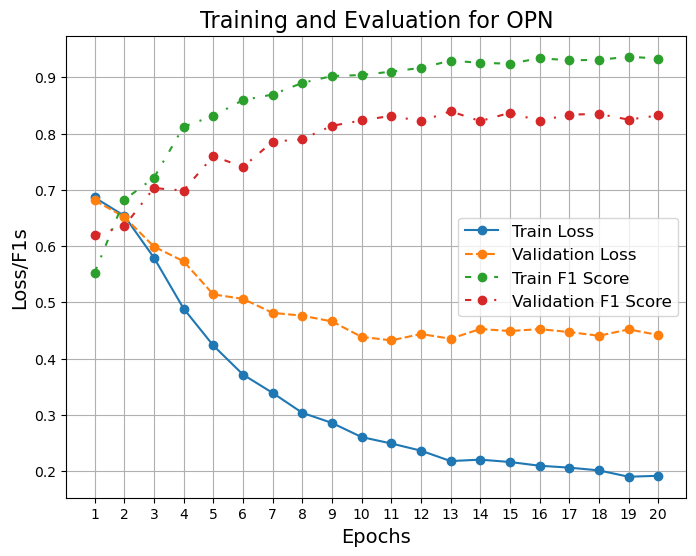

Training for category: CON


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training type set to: all_training


Training type set to: all_training

--------------------------------------------------
Training Started. Models saved to models/Big5_CON_all_training
--------------------------------------------------



Epoch 20/20
+-----------+---------+--------------+
| Metric    |   Train |   Validation |
+===========+=========+==============+
| Precision |  0.938  |       0.8934 |
+-----------+---------+--------------+
| Recall    |  0.9306 |       0.8838 |
+-----------+---------+--------------+
| Accuracy  |  0.9306 |       0.8838 |
+-----------+---------+--------------+
| F1 Score  |  0.9307 |       0.8841 |
+-----------+---------+--------------+


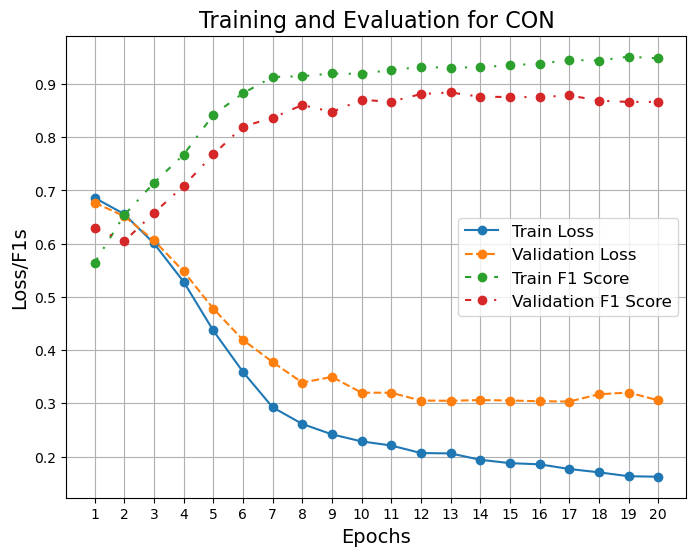

Training for category: EXT


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training type set to: all_training


Training type set to: all_training

--------------------------------------------------
Training Started. Models saved to models/Big5_EXT_all_training
--------------------------------------------------



Epoch 20/20
+-----------+---------+--------------+
| Metric    |   Train |   Validation |
+===========+=========+==============+
| Precision |  0.9146 |       0.8537 |
+-----------+---------+--------------+
| Recall    |  0.9009 |       0.8311 |
+-----------+---------+--------------+
| Accuracy  |  0.9009 |       0.8311 |
+-----------+---------+--------------+
| F1 Score  |  0.9008 |       0.8316 |
+-----------+---------+--------------+


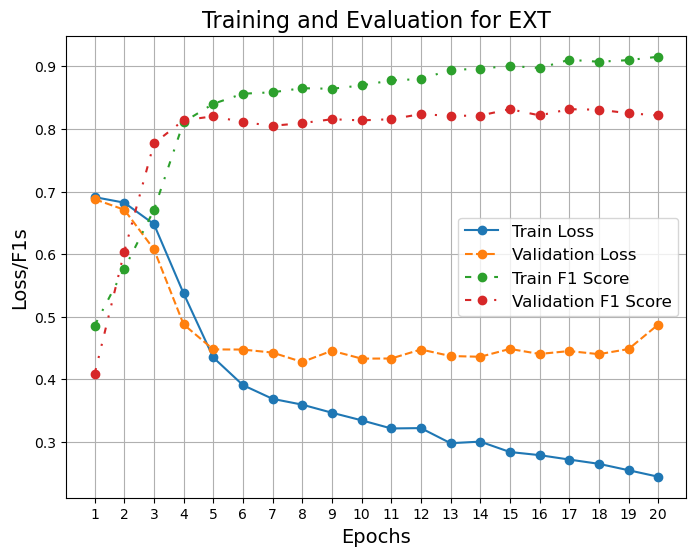

Training for category: AGR


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training type set to: all_training


Training type set to: all_training

--------------------------------------------------
Training Started. Models saved to models/Big5_AGR_all_training
--------------------------------------------------



Epoch 20/20
+-----------+---------+--------------+
| Metric    |   Train |   Validation |
+===========+=========+==============+
| Precision |  0.8623 |       0.7998 |
+-----------+---------+--------------+
| Recall    |  0.8491 |       0.773  |
+-----------+---------+--------------+
| Accuracy  |  0.8491 |       0.773  |
+-----------+---------+--------------+
| F1 Score  |  0.8491 |       0.7743 |
+-----------+---------+--------------+


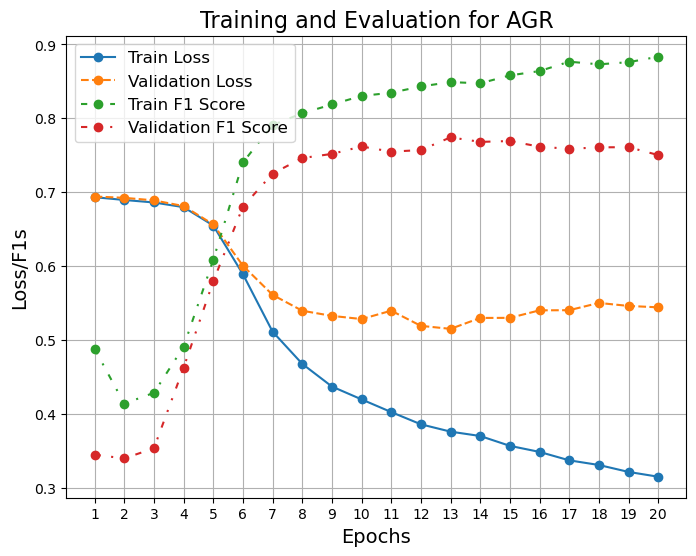

Training for category: NEU


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training type set to: all_training


Training type set to: all_training

--------------------------------------------------
Training Started. Models saved to models/Big5_NEU_all_training
--------------------------------------------------



Epoch 20/20
+-----------+---------+--------------+
| Metric    |   Train |   Validation |
+===========+=========+==============+
| Precision |  0.8838 |       0.7413 |
+-----------+---------+--------------+
| Recall    |  0.862  |       0.7007 |
+-----------+---------+--------------+
| Accuracy  |  0.862  |       0.7007 |
+-----------+---------+--------------+
| F1 Score  |  0.8612 |       0.7069 |
+-----------+---------+--------------+


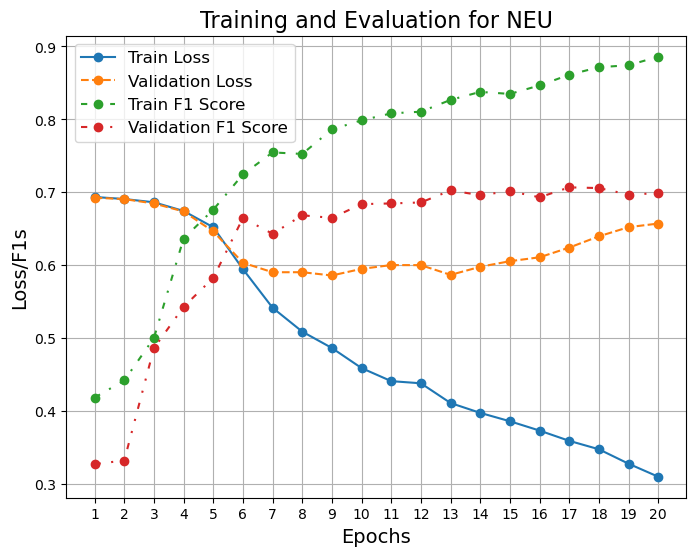

In [43]:
big5categories = ["OPN", "CON", "EXT", "AGR", "NEU"]

# Loop over each category
for category in big5categories:
    print(f"Training for category: {category}")
    trainer = Trainer(
        big5category=category,  # Dynamically set the category
        batch_size=BATCH_SIZE,
        device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
        epochs=20,
        learning_rate=1e-6,
        save_path=SAVE_PATH + f'_{category}_all_training',  # Save path specific to each category
        training_type='all_training',
        train_data=train_data,
        eval_data=eval_data
    )
    trainer.execute()  # Execute training for the current category


Training for category: OPN


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training type set to: bottom_4_training


Training type set to: bottom_4_training

--------------------------------------------------
Training Started. Models saved to models/Big5_OPN_bottom_4_training
--------------------------------------------------



Epoch 20/20
+-----------+---------+--------------+
| Metric    |   Train |   Validation |
+===========+=========+==============+
| Precision |  0.8836 |       0.773  |
+-----------+---------+--------------+
| Recall    |  0.8674 |       0.7533 |
+-----------+---------+--------------+
| Accuracy  |  0.8674 |       0.7533 |
+-----------+---------+--------------+
| F1 Score  |  0.8673 |       0.7529 |
+-----------+---------+--------------+


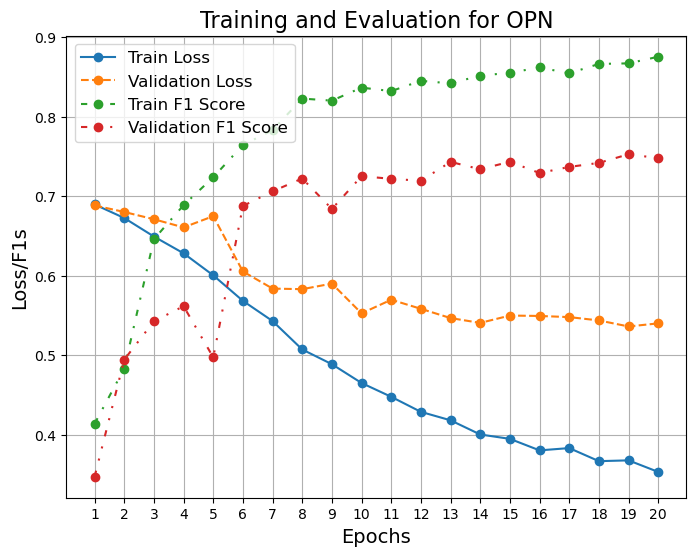

Training for category: CON


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training type set to: bottom_4_training


Training type set to: bottom_4_training

--------------------------------------------------
Training Started. Models saved to models/Big5_CON_bottom_4_training
--------------------------------------------------



Epoch 20/20
+-----------+---------+--------------+
| Metric    |   Train |   Validation |
+===========+=========+==============+
| Precision |  0.9163 |       0.8472 |
+-----------+---------+--------------+
| Recall    |  0.9085 |       0.8147 |
+-----------+---------+--------------+
| Accuracy  |  0.9085 |       0.8147 |
+-----------+---------+--------------+
| F1 Score  |  0.9081 |       0.8166 |
+-----------+---------+--------------+


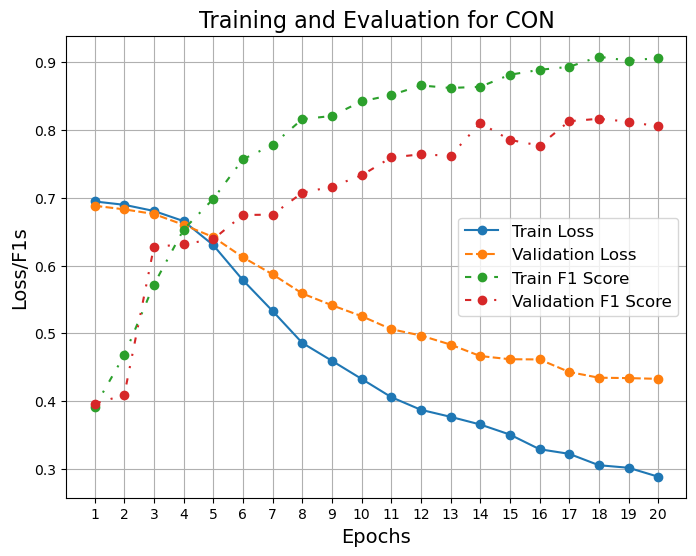

Training for category: EXT


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training type set to: bottom_4_training


Training type set to: bottom_4_training

--------------------------------------------------
Training Started. Models saved to models/Big5_EXT_bottom_4_training
--------------------------------------------------



Epoch 20/20
+-----------+---------+--------------+
| Metric    |   Train |   Validation |
+===========+=========+==============+
| Precision |  0.8437 |       0.7954 |
+-----------+---------+--------------+
| Recall    |  0.8238 |       0.784  |
+-----------+---------+--------------+
| Accuracy  |  0.8238 |       0.784  |
+-----------+---------+--------------+
| F1 Score  |  0.823  |       0.7844 |
+-----------+---------+--------------+


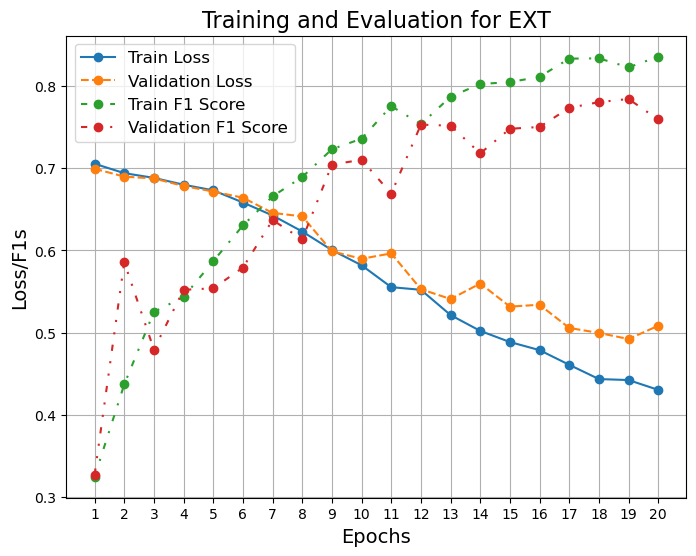

Training for category: AGR


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training type set to: bottom_4_training


Training type set to: bottom_4_training

--------------------------------------------------
Training Started. Models saved to models/Big5_AGR_bottom_4_training
--------------------------------------------------



Epoch 20/20
+-----------+---------+--------------+
| Metric    |   Train |   Validation |
+===========+=========+==============+
| Precision |  0.828  |       0.7706 |
+-----------+---------+--------------+
| Recall    |  0.8079 |       0.7412 |
+-----------+---------+--------------+
| Accuracy  |  0.8079 |       0.7412 |
+-----------+---------+--------------+
| F1 Score  |  0.8077 |       0.7426 |
+-----------+---------+--------------+


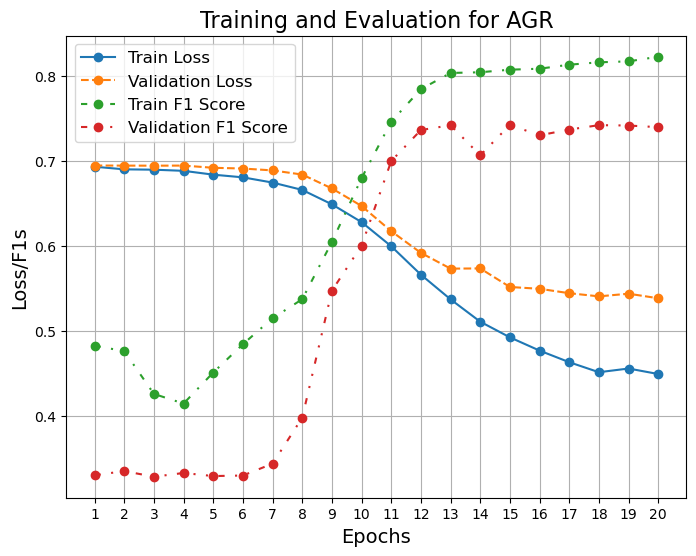

Training for category: NEU


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training type set to: bottom_4_training


Training type set to: bottom_4_training

--------------------------------------------------
Training Started. Models saved to models/Big5_NEU_bottom_4_training
--------------------------------------------------



Epoch 20/20
+-----------+---------+--------------+
| Metric    |   Train |   Validation |
+===========+=========+==============+
| Precision |  0.7282 |       0.6737 |
+-----------+---------+--------------+
| Recall    |  0.6825 |       0.6414 |
+-----------+---------+--------------+
| Accuracy  |  0.6825 |       0.6414 |
+-----------+---------+--------------+
| F1 Score  |  0.6732 |       0.6362 |
+-----------+---------+--------------+


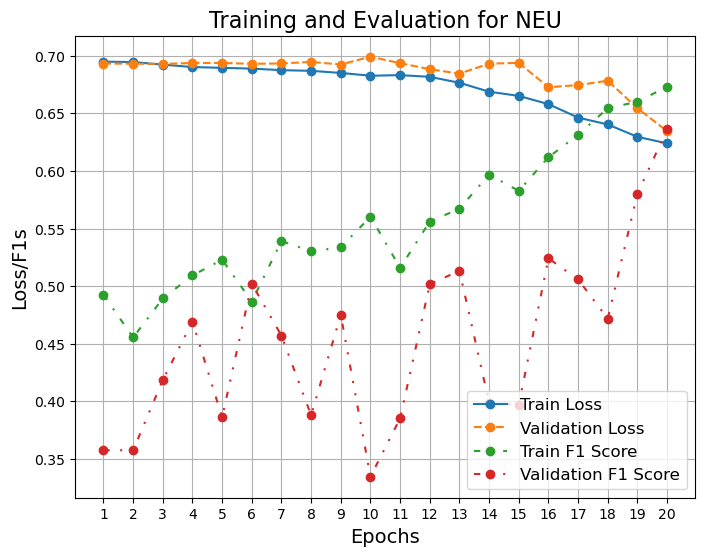

In [44]:
for category in big5categories:
    print(f"Training for category: {category}")
    trainer = Trainer(
        big5category=category,  # Dynamically set the category
        batch_size=BATCH_SIZE,
        device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
        epochs=20,
        learning_rate=1e-6,
        save_path=SAVE_PATH + f'_{category}_bottom_4_training',  # Save path specific to each category
        training_type='bottom_4_training',
        train_data=train_data,
        eval_data=eval_data
    )
    trainer.execute()  # Execute training for the current category


Training for category: OPN


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training type set to: top_4_training


Training type set to: top_4_training

--------------------------------------------------
Training Started. Models saved to models/Big5_OPN_top_4_training
--------------------------------------------------



Epoch 20/20
+-----------+---------+--------------+
| Metric    |   Train |   Validation |
+===========+=========+==============+
| Precision |  0.9305 |       0.8464 |
+-----------+---------+--------------+
| Recall    |  0.9213 |       0.8333 |
+-----------+---------+--------------+
| Accuracy  |  0.9213 |       0.8333 |
+-----------+---------+--------------+
| F1 Score  |  0.9211 |       0.8309 |
+-----------+---------+--------------+


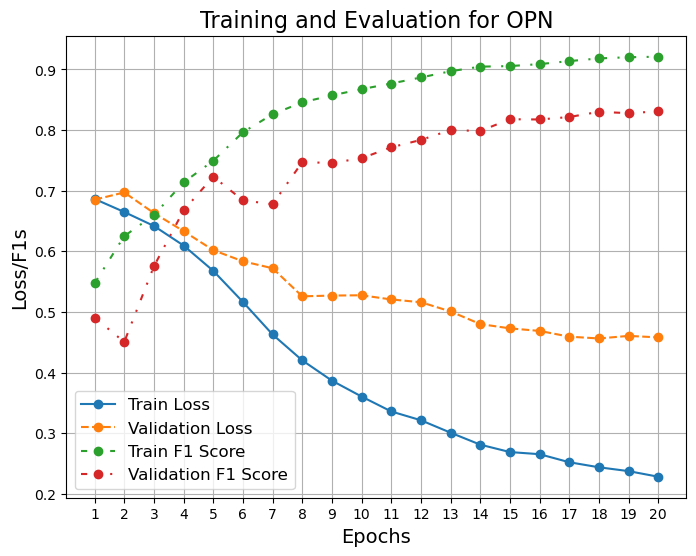

Training for category: CON


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training type set to: top_4_training


Training type set to: top_4_training

--------------------------------------------------
Training Started. Models saved to models/Big5_CON_top_4_training
--------------------------------------------------



Epoch 20/20
+-----------+---------+--------------+
| Metric    |   Train |   Validation |
+===========+=========+==============+
| Precision |  0.9462 |       0.8989 |
+-----------+---------+--------------+
| Recall    |  0.9375 |       0.8904 |
+-----------+---------+--------------+
| Accuracy  |  0.9375 |       0.8904 |
+-----------+---------+--------------+
| F1 Score  |  0.9375 |       0.8903 |
+-----------+---------+--------------+


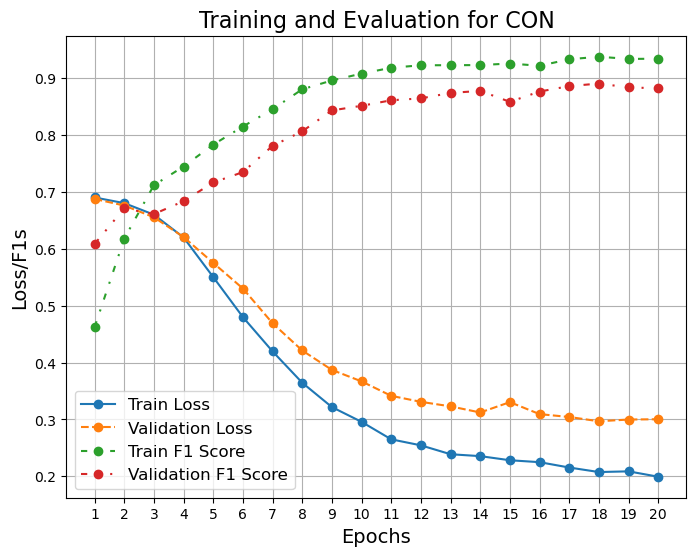

Training for category: EXT


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training type set to: top_4_training


Training type set to: top_4_training

--------------------------------------------------
Training Started. Models saved to models/Big5_EXT_top_4_training
--------------------------------------------------



Epoch 20/20
+-----------+---------+--------------+
| Metric    |   Train |   Validation |
+===========+=========+==============+
| Precision |  0.8942 |       0.8422 |
+-----------+---------+--------------+
| Recall    |  0.8811 |       0.8246 |
+-----------+---------+--------------+
| Accuracy  |  0.8811 |       0.8246 |
+-----------+---------+--------------+
| F1 Score  |  0.8812 |       0.825  |
+-----------+---------+--------------+


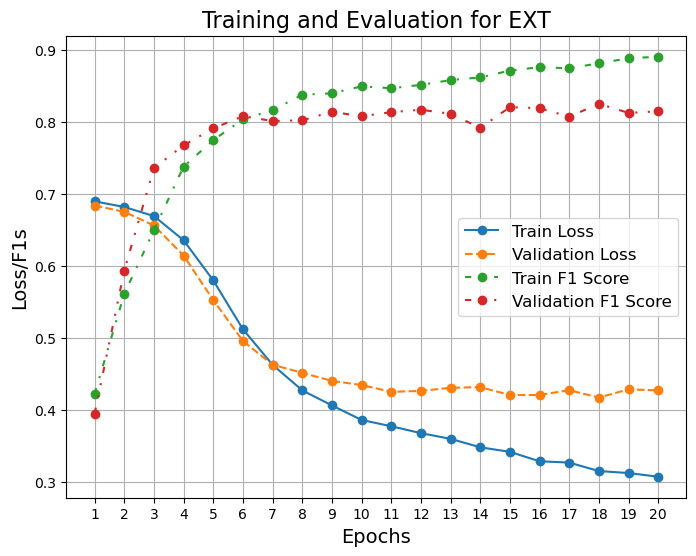

Training for category: AGR


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training type set to: top_4_training


Training type set to: top_4_training

--------------------------------------------------
Training Started. Models saved to models/Big5_AGR_top_4_training
--------------------------------------------------



Epoch 20/20
+-----------+---------+--------------+
| Metric    |   Train |   Validation |
+===========+=========+==============+
| Precision |  0.8485 |       0.7965 |
+-----------+---------+--------------+
| Recall    |  0.8267 |       0.7544 |
+-----------+---------+--------------+
| Accuracy  |  0.8267 |       0.7544 |
+-----------+---------+--------------+
| F1 Score  |  0.8282 |       0.7571 |
+-----------+---------+--------------+


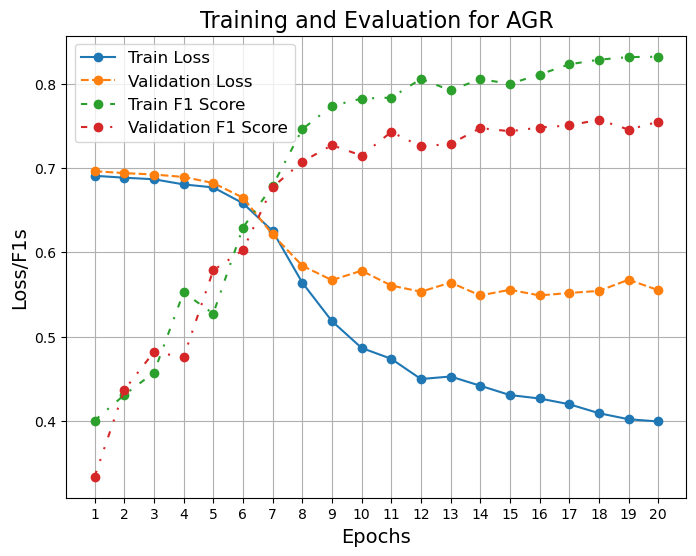

Training for category: NEU


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training type set to: top_4_training


Training type set to: top_4_training

--------------------------------------------------
Training Started. Models saved to models/Big5_NEU_top_4_training
--------------------------------------------------



Epoch 20/20
+-----------+---------+--------------+
| Metric    |   Train |   Validation |
+===========+=========+==============+
| Precision |  0.8158 |       0.7398 |
+-----------+---------+--------------+
| Recall    |  0.7942 |       0.6996 |
+-----------+---------+--------------+
| Accuracy  |  0.7942 |       0.6996 |
+-----------+---------+--------------+
| F1 Score  |  0.7935 |       0.6995 |
+-----------+---------+--------------+


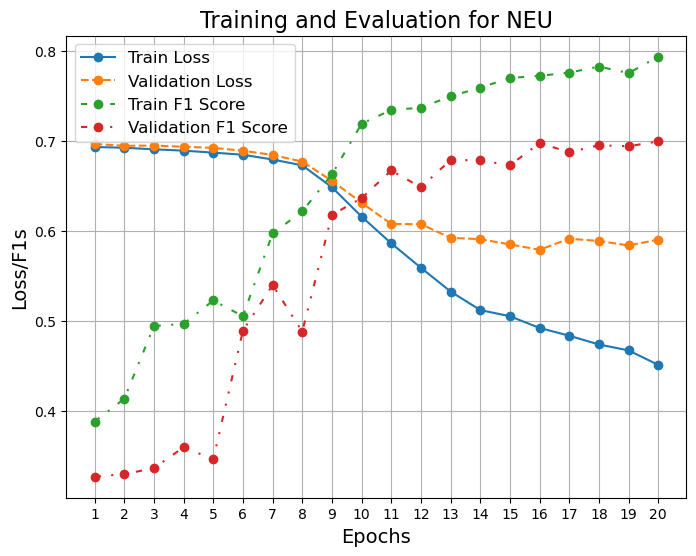

In [45]:
for category in big5categories:
    print(f"Training for category: {category}")
    trainer = Trainer(
        big5category=category,  # Dynamically set the category
        batch_size=BATCH_SIZE,
        device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
        epochs=20,
        learning_rate=1e-6,
        save_path=SAVE_PATH + f'_{category}_top_4_training',  # Save path specific to each category
        training_type='top_4_training',
        train_data=train_data,
        eval_data=eval_data
    )
    trainer.execute()  # Execute training for the current category


Training for category: OPN


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training type set to: fully_frozen


Training type set to: fully_frozen

--------------------------------------------------
Training Started. Models saved to models/Big5_OPN_fully_frozen
--------------------------------------------------



Epoch 20/20
+-----------+---------+--------------+
| Metric    |   Train |   Validation |
+===========+=========+==============+
| Precision |  0.4129 |       0.2603 |
+-----------+---------+--------------+
| Recall    |  0.4963 |       0.4879 |
+-----------+---------+--------------+
| Accuracy  |  0.4963 |       0.4879 |
+-----------+---------+--------------+
| F1 Score  |  0.3744 |       0.3343 |
+-----------+---------+--------------+


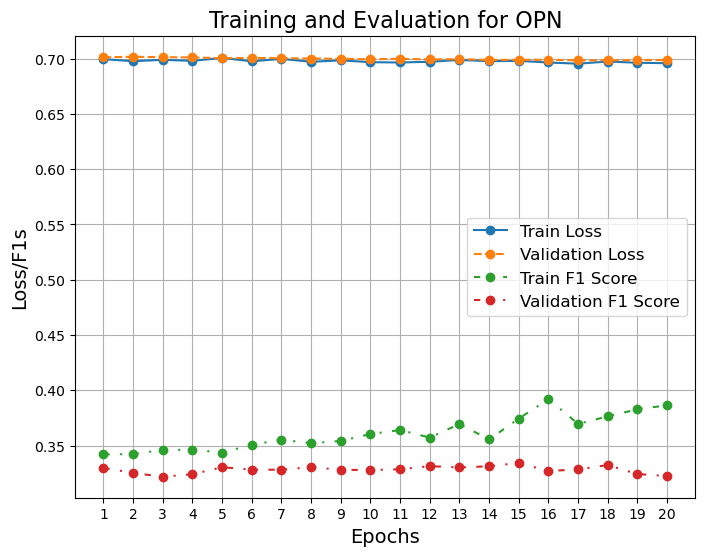

Training for category: CON


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training type set to: fully_frozen


Training type set to: fully_frozen

--------------------------------------------------
Training Started. Models saved to models/Big5_CON_fully_frozen
--------------------------------------------------



Epoch 20/20
+-----------+---------+--------------+
| Metric    |   Train |   Validation |
+===========+=========+==============+
| Precision |  0.4992 |       0.3365 |
+-----------+---------+--------------+
| Recall    |  0.5172 |       0.5515 |
+-----------+---------+--------------+
| Accuracy  |  0.5172 |       0.5515 |
+-----------+---------+--------------+
| F1 Score  |  0.4162 |       0.4097 |
+-----------+---------+--------------+


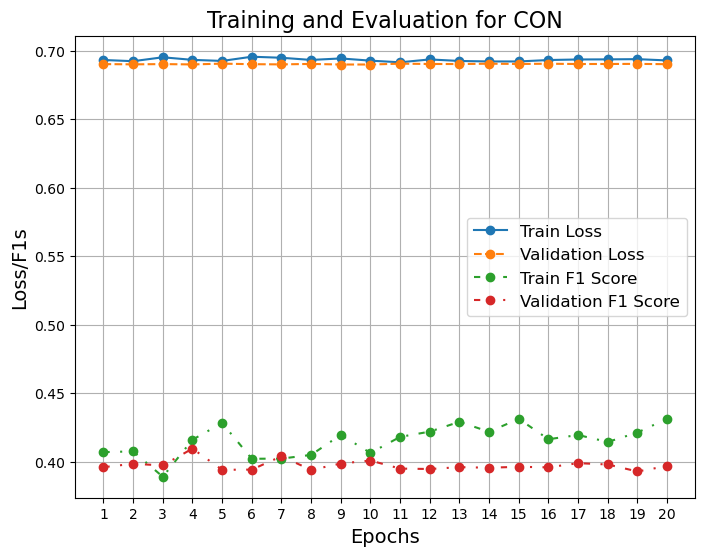

Training for category: EXT


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training type set to: fully_frozen


Training type set to: fully_frozen

--------------------------------------------------
Training Started. Models saved to models/Big5_EXT_fully_frozen
--------------------------------------------------



Epoch 20/20
+-----------+---------+--------------+
| Metric    |   Train |   Validation |
+===========+=========+==============+
| Precision |  0.5213 |       0.3795 |
+-----------+---------+--------------+
| Recall    |  0.5003 |       0.5252 |
+-----------+---------+--------------+
| Accuracy  |  0.5003 |       0.5252 |
+-----------+---------+--------------+
| F1 Score  |  0.4928 |       0.3837 |
+-----------+---------+--------------+


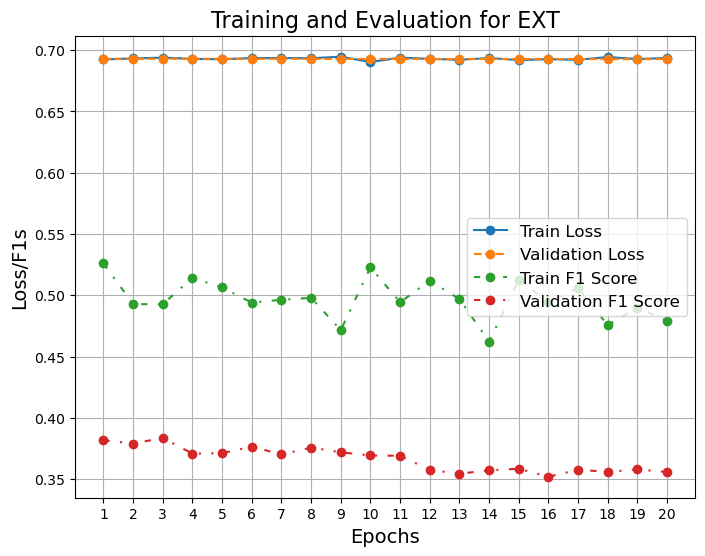

Training for category: AGR


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training type set to: fully_frozen


Training type set to: fully_frozen

--------------------------------------------------
Training Started. Models saved to models/Big5_AGR_fully_frozen
--------------------------------------------------



Epoch 20/20
+-----------+---------+--------------+
| Metric    |   Train |   Validation |
+===========+=========+==============+
| Precision |  0.5083 |       0.5289 |
+-----------+---------+--------------+
| Recall    |  0.4738 |       0.5033 |
+-----------+---------+--------------+
| Accuracy  |  0.4738 |       0.5033 |
+-----------+---------+--------------+
| F1 Score  |  0.4748 |       0.4988 |
+-----------+---------+--------------+


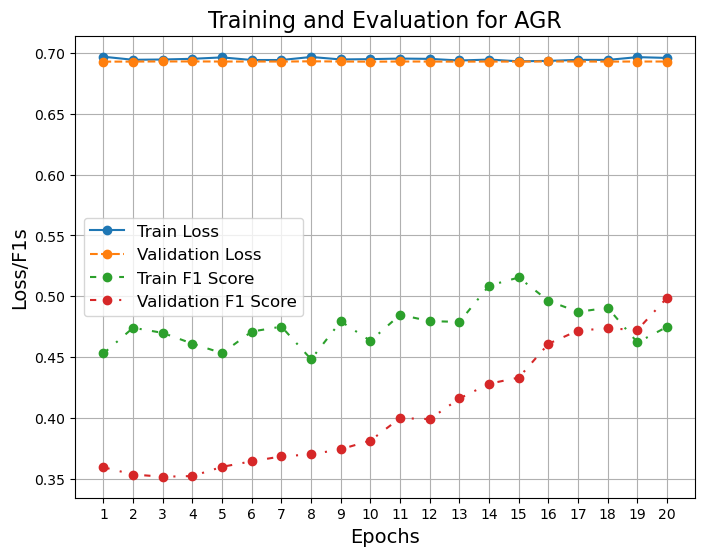

Training for category: NEU


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training type set to: fully_frozen


Training type set to: fully_frozen

--------------------------------------------------
Training Started. Models saved to models/Big5_NEU_fully_frozen
--------------------------------------------------



Epoch 20/20
+-----------+---------+--------------+
| Metric    |   Train |   Validation |
+===========+=========+==============+
| Precision |  0.5336 |       0.2632 |
+-----------+---------+--------------+
| Recall    |  0.5168 |       0.4934 |
+-----------+---------+--------------+
| Accuracy  |  0.5168 |       0.4934 |
+-----------+---------+--------------+
| F1 Score  |  0.4477 |       0.3381 |
+-----------+---------+--------------+


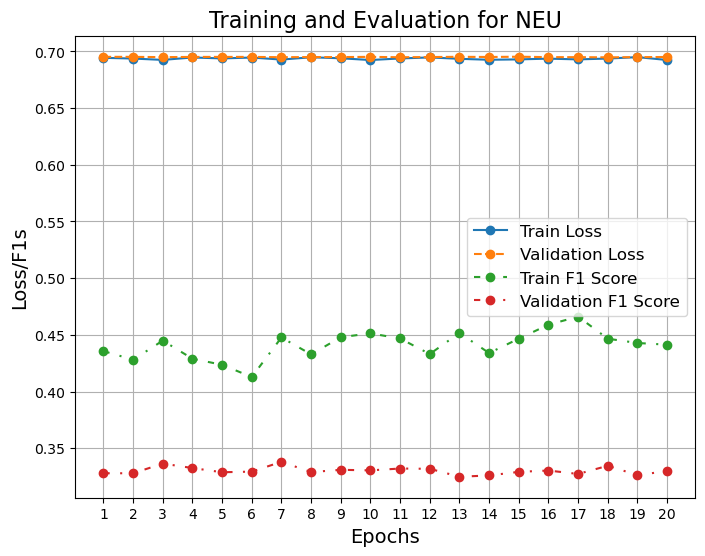

In [46]:
for category in big5categories:
    print(f"Training for category: {category}")
    trainer = Trainer(
        big5category=category,  # Dynamically set the category
        batch_size=BATCH_SIZE,
        device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
        epochs=20,
        learning_rate=1e-6,
        save_path=SAVE_PATH + f'_{category}_fully_frozen',  # Save path specific to each category
        training_type='fully_frozen',
        train_data=train_data,
        eval_data=eval_data
    )
    trainer.execute()  # Execute training for the current category


# Testing


In [27]:
class Tester():

  def __init__(self, big5category, save_path, device, test_data, batch_size):
    self.big5category = big5category
    self.save_path = save_path
    self.device = device
    self.batch_size = batch_size
    transformer = Big5Classifier(self.save_path)
    self.model, self.tokenizer = transformer.get_tokenizer_and_model()
    self.model.to(self.device)

    self.test_dataset = DatasetLoader(test_data, self.tokenizer, big5category)

  def get_performance_metrics(self, preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    accuracy = accuracy_score(labels_flat, pred_flat)
    precision = precision_score(labels_flat, pred_flat, zero_division=0, average="weighted")
    recall = recall_score(labels_flat, pred_flat, zero_division=0, average="weighted")
    f1 = f1_score(labels_flat, pred_flat, zero_division=0, average="weighted")
    return precision, recall, f1, accuracy

  def test(self, data_loader):
    self.model.eval()
    total_recall = 0
    total_precision = 0
    total_accuracy = 0
    total_f1 = 0

    with torch.no_grad():
        for (answers, labels) in (tqdm(data_loader, leave=False)):
            self.model.zero_grad()
            answers, labels = answers.to(self.device), labels.to(self.device)
            outputs = self.model(answers, labels=labels)

            preds = outputs.logits.detach().cpu().numpy()
            labels_np = labels.cpu().numpy()
            precision, recall, f1, accuracy = self.get_performance_metrics(preds, labels_np)
            total_precision += precision
            total_recall += recall
            total_accuracy += accuracy
            total_f1 += f1

        precision = total_precision/len(data_loader)
        recall = total_recall/len(data_loader)
        f1 = total_f1/len(data_loader)
        accuracy = total_accuracy/len(data_loader)
    return precision, recall, f1, accuracy

  def execute(self):
    test_data_loader = self.test_dataset.get_data_loaders(self.batch_size)
    return self.test(test_data_loader)


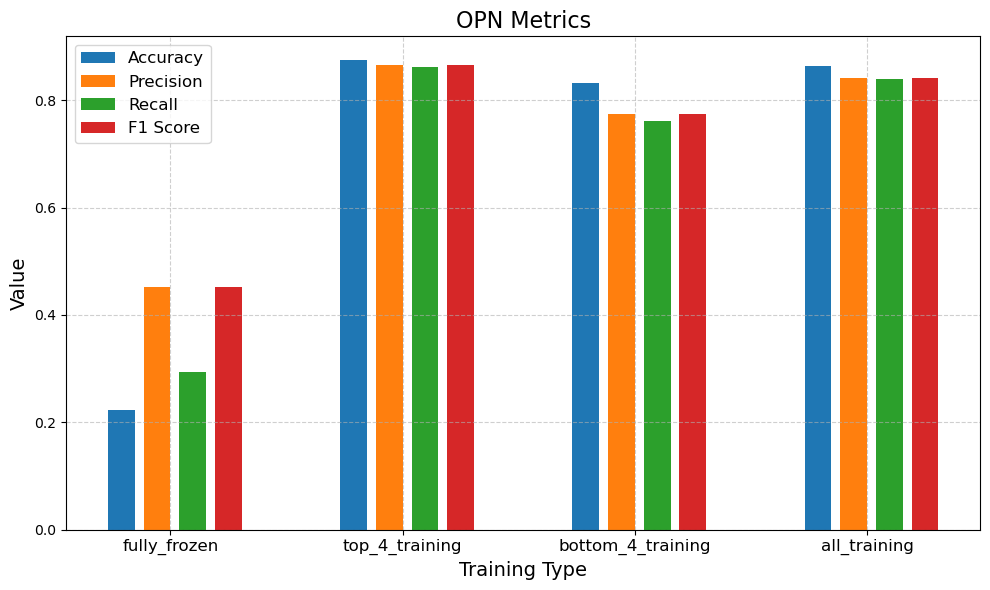

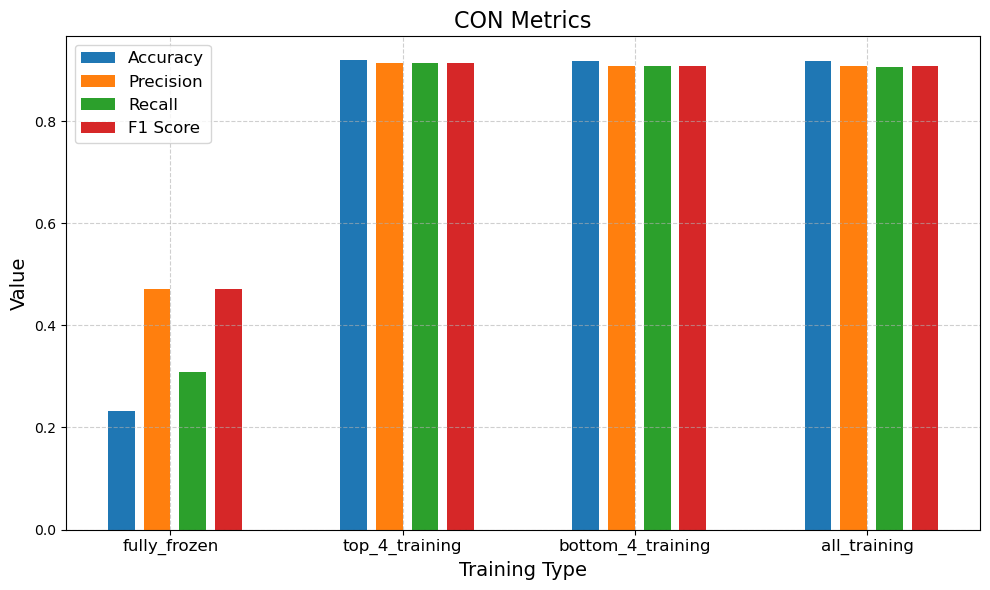

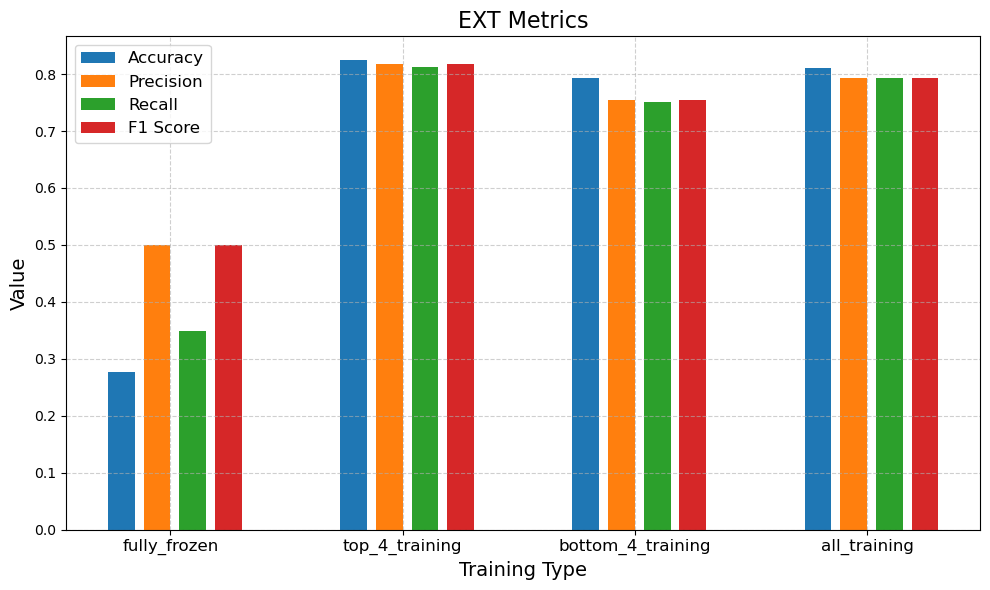

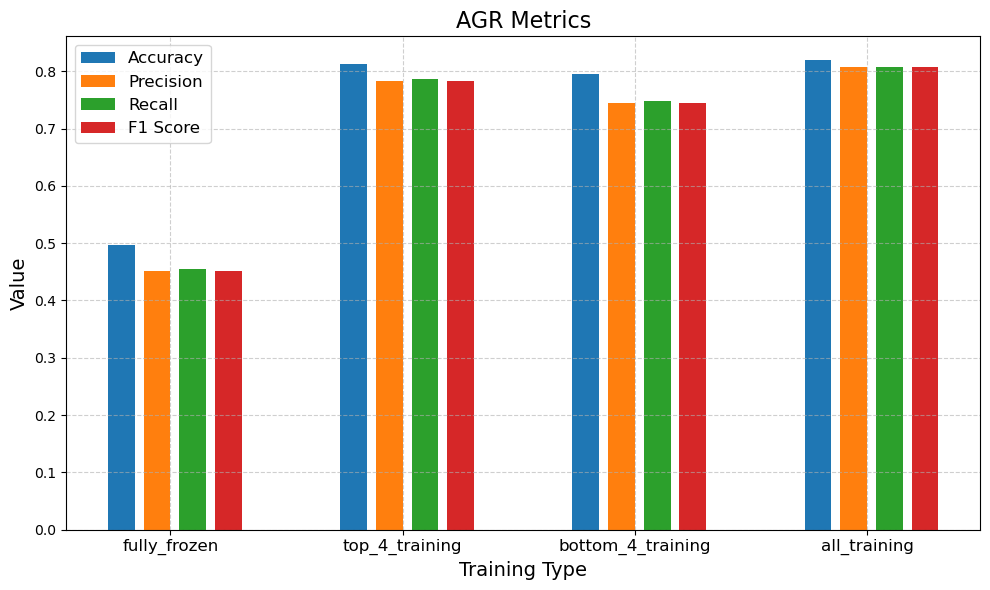

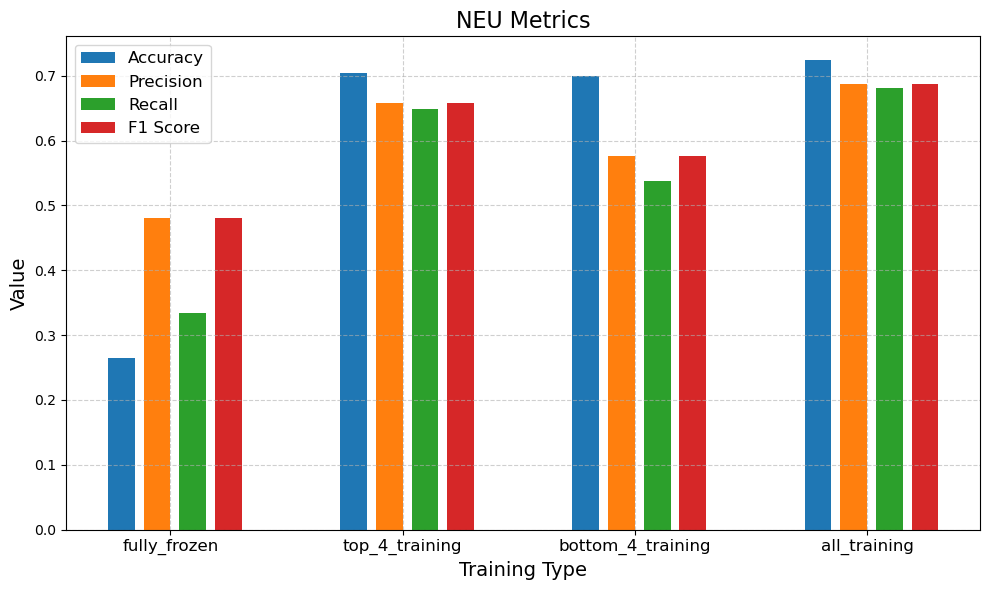

In [ ]:
# Initialize data storage
big5categories = ["OPN", "CON", "EXT", "AGR", "NEU"]
training_types = ["fully_frozen", "top_4_training", "bottom_4_training", "all_training"]

metrics_data = {
    category: {train_type: None for train_type in training_types} for category in big5categories
}

# Collect data
for category in big5categories:
    for train_type in training_types:
        tester = Tester(
            big5category=category,
            save_path=SAVE_PATH + f'_{category}_{train_type}',  # Save path specific to each category
            device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
            test_data=test_data,
            batch_size=BATCH_SIZE,
        )
        test_precision, test_recall, test_f1, test_loss = tester.execute()
        metrics_data[category][train_type] = [test_precision, test_recall, test_f1, test_loss]

# Plot for each category
metrics = ["Accuracy", "Precision", "Recall", "F1 Score"]
for category in big5categories:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Extract metrics for the current category
    training_metrics = metrics_data[category]
    
    # Organize data for plotting
    group_spacing = 0.2  # Space between groups
    width = 0.15         # Thinner bars
    bar_spacing = 0.05   # Space between individual bars in a group
    
    x = np.arange(len(training_types)) * (1 + group_spacing)  # Adjust x positions for group spacing
    offsets = [-1.5 * width - bar_spacing, -0.5 * width, 0.5 * width + bar_spacing, 1.5 * width + 2 * bar_spacing]
    
    # Plot each metric
    for i, metric in enumerate(metrics):
        values = [training_metrics[train_type][i] for train_type in training_types]
        ax.bar(x + offsets[i], values, width, label=metric)
    
    # Customize the plot
    ax.set_title(f"{category} Metrics", fontsize=16)
    ax.set_xlabel("Training Type", fontsize=14)
    ax.set_ylabel("Value", fontsize=14)
    ax.set_xticks(x)  # Adjusted to new group spacing
    ax.set_xticklabels(training_types, fontsize=12)
    ax.legend(fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.6)
    
    # Show the plot
    plt.tight_layout()
    plt.show()
